## [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [168]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [169]:
def plot_losses(losses):
  import matplotlib.pyplot as plt
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

### Micrograd Classes and Functions

In [170]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [171]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [172]:
import random

class Neuron:
    
    def __init__(self, nin):
#### my add ##########################################        
        # random.seed(12345)  # WARNING: all neurons will have the same weights and bias
######################################################        
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

### Neuron in Neural Network
<!-- ### Simple Neural Network: Single Neuron with 3 Inputs -->
<img src="..\karpathy\img\Nertual_Network_1_Neuron_3_Inputs.png">

#### Activation Function: Tanh

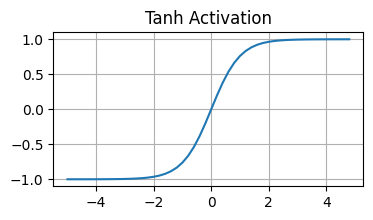

In [173]:
_num = np.arange(-5, 5, 0.2)
plt.figure(figsize=(4, 2))
plt.plot(_num, np.tanh(_num))
plt.title("Tanh Activation")
plt.grid()

##### Calculate Output with Forward Pass

In [174]:
# inputs
x0 = Value(-3.0, label='x0')
x1 = Value(0.0, label='x1')
x2 = Value(0.5, label='x2')

# weights
w0 = Value(2.0, label='w0')
w1 = Value(1.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(4.618626415, label='b')

# forward pass
# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_0 = n.tanh(); out_0.label = 'out_0'
print(f'neuron output: {out_0.data}')

neuron output: -0.7071067801767762


##### Calculate Gradient with Backward Pass

w0.grad(i.e. d(output)/d(w0)): -1.500000004284097


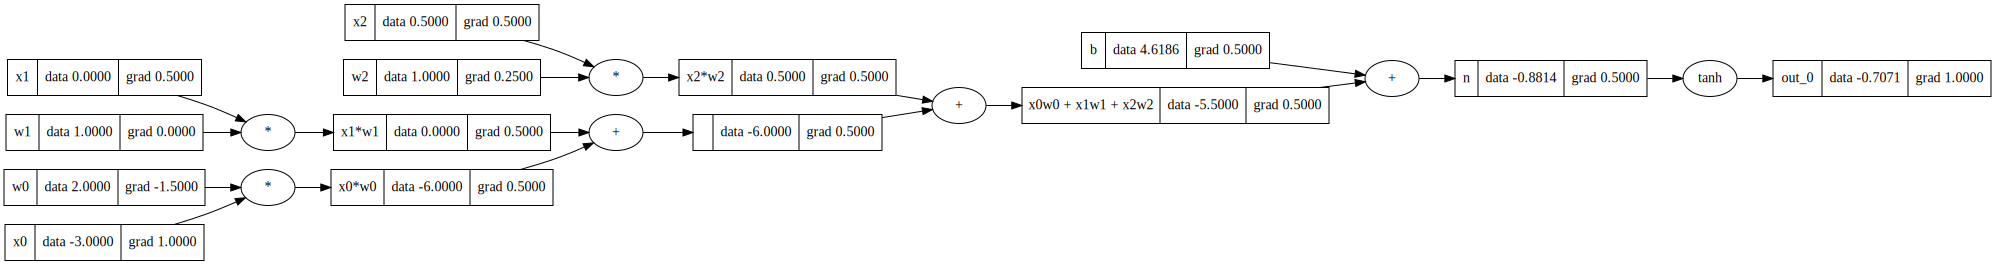

In [175]:
# backward pass to calculate gradient
out_0.backward()
  
out_0_grad = w0.grad  # store w0.grad, further calculation with w0 will reset w0.grad to zero
print(f'w0.grad(i.e. d(output)/d(w0)): {w0.grad}')
draw_dot(out_0)

##### Check Backward Pass Gradient Calculation: d(output) / d(x0)

In [176]:
h = 0.000001
w0 += h  # increment x0 by h

# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_1 = n.tanh(); out_1.label = 'out_1'
out_grad = (out_1 - out_0) / h 

print(f'---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----')
print(f'out_1: {out_1.data:<12.10f}, out_0: {out_0.data:<12.10f}, d(out): {out_1.data-out_0.data:<12.10f}, d(w0): {h:<12.10f}, d(out)/d(w0): {(out_1.data-out_0.data)/h:<12.10f}')
print(f'd(out) / d(w0):             {out_grad.data:<12.10f}')
print(f'w0.grad from backward pass: {out_0_grad:<12.10f}')

---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----
out_1: -0.7071082802, out_0: -0.7071067802, d(out): -0.0000015000, d(w0): 0.0000010000, d(out)/d(w0): -1.4999968224
d(out) / d(w0):             -1.4999968224
w0.grad from backward pass: -1.5000000043


##### Check Output and Gradient Calculation with PyTorch

In [177]:
import torch

In [178]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <--')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <--')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <--
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <--


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [179]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [180]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'len(n.parameters()): {len(n.parameters())}')
# n.parameters()
for i, v in enumerate(n.parameters()):
  print(f'i: {i:>2}, {v.data:>14.10f}')

len(n.parameters()): 41
i:  0,  -0.3819290036
i:  1,   0.6317974535
i:  2,   0.7726649063
i:  3,   0.8696652787
i:  4,   0.8458581259
i:  5,   0.5584484293
i:  6,  -0.9821967140
i:  7,  -0.0795786360
i:  8,  -0.1827644704
i:  9,  -0.3661098477
i: 10,   0.1624196143
i: 11,  -0.2659989119
i: 12,  -0.6504692033
i: 13,  -0.3906224270
i: 14,  -0.2347982804
i: 15,  -0.4320641710
i: 16,  -0.3490199945
i: 17,  -0.3942043091
i: 18,   0.8903179142
i: 19,   0.2588452161
i: 20,   0.0810092911
i: 21,  -0.9744730925
i: 22,   0.1062313155
i: 23,   0.3346382585
i: 24,   0.8131008921
i: 25,   0.9370245801
i: 26,  -0.1051753210
i: 27,  -0.6249804634
i: 28,  -0.1431672044
i: 29,  -0.8928909390
i: 30,  -0.4323844349
i: 31,  -0.3753338373
i: 32,  -0.6148761039
i: 33,  -0.2552803752
i: 34,  -0.4619117418
i: 35,   0.8756631459
i: 36,  -0.6593324357
i: 37,   0.7618787623
i: 38,   0.7946382746
i: 39,   0.7608168201
i: 40,  -0.6043261708


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [181]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [182]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}')
        print(f'b_mat:  {b_mat}')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('----')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
neuron 0
w0: -0.3819290,   w0.grad:  0.0000000
w1:  0.6317975,   w1.grad:  0.0000000
w2:  0.7726649,   w2.grad:  0.0000000
b:   0.8696653
b_mat:  [0.8696652786603714]
neuron 1
w0:  0.8458581,   w0.grad:  0.0000000
w1:  0.5584484,   w1.grad:  0.0000000
w2: -0.9821967,   w2.grad:  0.0000000
b:  -0.0795786
b_mat:  [0.8696652786603714, -0.07957863596117543]
neuron 2
w0: -0.1827645,   w0.grad:  0.0000000
w1: -0.3661098,   w1.grad:  0.0000000
w2:  0.1624196,   w2.grad:  0.0000000
b:  -0.2659989
b_mat:  [0.8696652786603714, -0.07957863596117543, -0.2659989119034638]
neuron 3
w0: -0.6504692,   w0.grad:  0.0000000
w1: -0.3906224,   w1.grad:  0.0000000
w2: -0.2347983,   w2.grad:  0.0000000
b:  -0.4320642
b_mat:  [0.8696652786603714, -0.07957863596117543, -0.2659989119034638, -0.43206417102041406]
----
layer: 1, neuron_cnt: 4
----
neuron 0
w0: -0.3490200,   w0.grad:  0.0000000
w1: -0.3942043,   w1.grad:  0.0000000
w2:  0.8903179,   w2.grad:  0.0000000
w3

##### Print Neural Network's Weights and Biases Matrices

In [183]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat:\n{w_n_b[0]}')
  print(f'b_mat:\n{w_n_b[1]}\n')  
    

i: 0
w_mat:
[[-0.381929    0.63179745  0.77266491]
 [ 0.84585813  0.55844843 -0.98219671]
 [-0.18276447 -0.36610985  0.16241961]
 [-0.6504692  -0.39062243 -0.23479828]]
b_mat:
[[ 0.86966528 -0.07957864 -0.26599891 -0.43206417]]

i: 1
w_mat:
[[-0.34901999 -0.39420431  0.89031791  0.25884522]
 [-0.97447309  0.10623132  0.33463826  0.81310089]
 [-0.10517532 -0.62498046 -0.1431672  -0.89289094]
 [-0.37533384 -0.6148761  -0.25528038 -0.46191174]]
b_mat:
[[ 0.08100929  0.93702458 -0.43238443  0.87566315]]

i: 2
w_mat:
[[-0.65933244  0.76187876  0.79463827  0.76081682]]
b_mat:
[[-0.60432617]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [184]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])
  output = np.tanh(np.matmul(weights, input) + bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')    
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[-0.381929    0.63179745  0.77266491]
 [ 0.84585813  0.55844843 -0.98219671]
 [-0.18276447 -0.36610985  0.16241961]
 [-0.6504692  -0.39062243 -0.23479828]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

bias (4, 1):
[[ 0.86966528]
 [-0.07957864]
 [-0.26599891]
 [-0.43206417]]

output (4, 2):
[[ 0.84215378 -0.47892373]
 [ 0.99960885  0.88716431]
 [-0.95557139 -0.3513409 ]
 [-0.9904554  -0.97104274]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[-0.34901999 -0.39420431  0.89031791  0.25884522]
 [-0.97447309  0.10623132  0.33463826  0.81310089]
 [-0.10517532 -0.62498046 -0.1431672  -0.89289094]
 [-0.37533384 -0.6148761  -0.25528038 -0.46191174]]

input (4, 2):
[[ 0.84215378 -0.47892373]
 [ 0.99960885  0.88716431]
 [-0.95557139 -0.3513409 ]
 [-0.9904554  -0.97104274]]

bias (4, 1):
[[ 0.08100929]
 [ 0.93702458]
 [-0.43238443]
 [ 0.87566315]]

output (4, 2):
[[-0.93714942 -

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [185]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [-0.19590600358895424, 0.6426884403416151]
ys:                 [1.0, -1.0]
loss_data:          4.128616481452072


#### Micrograd backward pass and update parameters

In [186]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0     -0.3819290036    -1.7564194009           0.05000        -0.2941080336
  1      0.6317974535     2.0751841528           0.05000         0.5280382459
  2      0.7726649063    -0.8344496647           0.05000         0.8143873895
  3      0.8696652787    -0.4500448592           0.05000         0.8921675216
  4      0.8458581259    -0.5503046628           0.05000         0.8733733590
  5      0.5584484293     0.1882787056           0.05000         0.5490344940
  6     -0.9821967140    -0.0934788322           0.05000        -0.9775227724
  7     -0.0795786360    -0.1829945405           0.05000        -0.0704289089
  8     -0.1827644704    -1.9232268263           0.05000        -0.0866031291
  9     -0.3661098477     0.7810926855           0.05000        -0.4051644820
 10      0.1624196143    -0.3714531050           0.05000         0.1809922695
 11     -0.2659989119    -0.6283467836

### Improve Prediction with Parameter Iteration 

In [187]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.2265915412618901), Value(data = 0.33166667936694344)]
step: 0, loss: 2.37149678898384
-------
ypred: [Value(data = 0.1905601272680768), Value(data = -0.6199407934432324)]
step: 1, loss: 0.7996379080568317
-------
ypred: [Value(data = 0.5563697453943329), Value(data = -0.5743600630886501)]
step: 2, loss: 0.37797715869538695
-------
ypred: [Value(data = 0.6140767864159401), Value(data = -0.6830021255453945)]
step: 3, loss: 0.24942437919178573
-------
ypred: [Value(data = 0.6679354389735458), Value(data = -0.7242053119982219)]
step: 4, loss: 0.18632958261968985
-------
ypred: [Value(data = 0.7045514404609251), Value(data = -0.7536804179830525)]
step: 5, loss: 0.147963187818718
-------
ypred: [Value(data = 0.731606497332289), Value(data = -0.7759039603940919)]
step: 6, loss: 0.12225410724129532
-------
ypred: [Value(data = 0.7526452056245346), Value(data = -0.7933845522151783)]
step: 7, loss: 0.10387433756385112
-------
ypred: [Value(data = 0.7696014656749262), Value

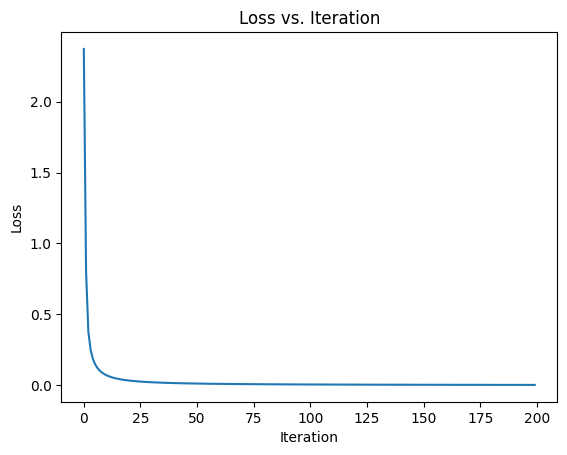

In [188]:
plot_losses(losses)

# TODO build same model with pyTorch 

In [189]:
# # create neural network and initialize weights and biases
# n = MLP(3, [4, 4, 1])

# # inputs
# xs = [
#   [2.0, 3.0, -1.0],
#   [3.0, -1.0, 0.5],
#   [5.0, -3.0, 1.5]  
# ]

# # desired targets
# ys = [1.0, -1.0, -.5]

# # learning rate (i.e. step size)
# learning_rate = 0.05

In [234]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)  
        return x

model = MLP()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(20):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)
    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print(f"Prediction: {prediction}")


Epoch 0 loss: 0.9543886184692383
Epoch 10 loss: 0.2784292697906494
Prediction: tensor([[ 0.8916],
        [-0.8765]], grad_fn=<AddmmBackward0>)


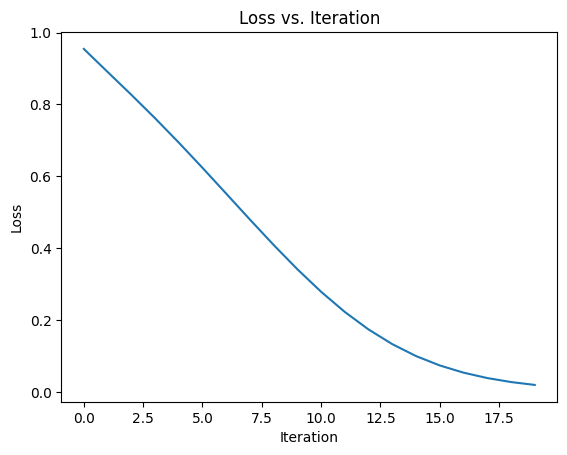

In [235]:
plot_losses(losses)

In [236]:
print(f'Input t_xs {t_xs.shape}:\n{t_xs}\n')
print(f'Target t_ys {t_ys.shape}:\n{t_ys}\n')
print(f'Prediction {prediction.shape}:\n{prediction}\n')

Input t_xs torch.Size([2, 3]):
tensor([[ 2.0000,  3.0000, -1.0000],
        [ 3.0000, -1.0000,  0.5000]])

Target t_ys torch.Size([2, 1]):
tensor([[ 1.],
        [-1.]])

Prediction torch.Size([2, 1]):
tensor([[ 0.8916],
        [-0.8765]], grad_fn=<AddmmBackward0>)



In [249]:
params = []
for i, param in enumerate(model.parameters()):
  params.append(param)
  print(f'params{i} {param.shape}:\n{param}\n')

params0 torch.Size([4, 3]):
Parameter containing:
tensor([[-0.2056,  0.5750, -0.3924],
        [-0.1006,  0.3268,  0.2469],
        [ 0.3394,  0.4781, -0.2451],
        [ 0.2419,  0.4848,  0.4186]], requires_grad=True)

params1 torch.Size([4]):
Parameter containing:
tensor([-0.3461, -0.3964,  0.3060, -0.2858], requires_grad=True)

params2 torch.Size([4, 4]):
Parameter containing:
tensor([[-0.4222, -0.4814,  0.1248, -0.5040],
        [-0.0140, -0.4809,  0.0380,  0.3247],
        [-0.6561, -0.2479, -0.3035, -0.4155],
        [ 0.2647, -0.3447, -0.2882, -0.2298]], requires_grad=True)

params3 torch.Size([4]):
Parameter containing:
tensor([ 0.0583,  0.1861,  0.4231, -0.0832], requires_grad=True)

params4 torch.Size([1, 4]):
Parameter containing:
tensor([[-0.6383,  0.0390, -0.6924,  0.2098]], requires_grad=True)

params5 torch.Size([1]):
Parameter containing:
tensor([0.1012], requires_grad=True)



In [288]:
w0 = torch.clone(params[0]).detach()
print(f'w0 {w0.shape}:\n{w0}\n')

x0 = torch.clone(t_xs)
print(f'x0 {x0.shape}:\n{x0}\n')

x0_T = torch.transpose(x0, 0, 1)
print(f'x0_T {x0_T.shape}:\n{x0_T}\n')

w0x0_T = torch.matmul(w0, x0_T)
print(f'w0x0_T {w0x0_T.shape}:\n{w0x0_T}\n')

b0 = torch.clone(params[1]).detach()
print(f'b0 {b0.shape}:\n{b0}\n')

b0_T = torch.unsqueeze(b0, 1)
print(f'b0_T {b0_T.shape}:\n{b0_T}\n')

w0x0_Tb0_T = torch.add(w0x0_T, b0_T)
print(f'w0x0_Tb0_T {w0x0_Tb0_T.shape}:\n{w0x0_Tb0_T}\n')

out0 = torch.tanh(w0x0_Tb0_T)
print(f'out0 {out0.shape}:\n{out0}\n')

# Layer 1
w1 = torch.clone(params[2]).detach()
print(f'w1 {w1.shape}:\n{w1}\n')

w1out0 = torch.matmul(w1, out0)
print(f'w1out0 {w1out0.shape}:\n{w1out0}\n')

b1 = torch.clone(params[3]).detach()
print(f'b1 {b1.shape}:\n{b1}\n')

b1_T = torch.unsqueeze(b1, 1)
print(f'b1_T {b1_T.shape}:\n{b1_T}\n')

w1out0b1_T = torch.add(w1out0, b1_T)
print(f'w1out0b1_T {w1out0b1_T.shape}:\n{w1out0b1_T}\n')

out1 = torch.tanh(w1out0b1_T)
print(f'out1 {out1.shape}:\n{out1}\n')

# Layer 2
w2 = torch.clone(params[4]).detach()
print(f'w2 {w2.shape}:\n{w2}\n')

w2out1 = torch.matmul(w2, out1)
print(f'w2out1 {w2out1.shape}:\n{w2out1}\n')

b2 = torch.clone(params[5]).detach()
print(f'b2 {b2.shape}:\n{b2}\n')

b2_T = torch.unsqueeze(b2, 1)
print(f'b2_T {b2_T.shape}:\n{b2_T}\n')

prediction = torch.add(w2out1, b2_T)  # no tanh activation on the last node from the model
print('--- prediction matched model output ---')
print(f'prediction {prediction.shape}:\n{prediction}\n')


w0 torch.Size([4, 3]):
tensor([[-0.2056,  0.5750, -0.3924],
        [-0.1006,  0.3268,  0.2469],
        [ 0.3394,  0.4781, -0.2451],
        [ 0.2419,  0.4848,  0.4186]])

x0 torch.Size([2, 3]):
tensor([[ 2.0000,  3.0000, -1.0000],
        [ 3.0000, -1.0000,  0.5000]])

x0_T torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w0x0_T torch.Size([4, 2]):
tensor([[ 1.7061, -1.3881],
        [ 0.5322, -0.5050],
        [ 2.3580,  0.4175],
        [ 1.5197,  0.4501]])

b0 torch.Size([4]):
tensor([-0.3461, -0.3964,  0.3060, -0.2858])

b0_T torch.Size([4, 1]):
tensor([[-0.3461],
        [-0.3964],
        [ 0.3060],
        [-0.2858]])

w0x0_Tb0_T torch.Size([4, 2]):
tensor([[ 1.3600, -1.7342],
        [ 0.1358, -0.9014],
        [ 2.6639,  0.7234],
        [ 1.2340,  0.1644]])

out0 torch.Size([4, 2]):
tensor([[ 0.8764, -0.9395],
        [ 0.1350, -0.7170],
        [ 0.9903,  0.6190],
        [ 0.8437,  0.1629]])

w1 torch.Size([4, 4]):
